<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-2-public/blob/adding_C4/C4/W1/assignment/C4_W1_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Train Your Own Model and Serve It With TensorFlow Serving

In this notebook, you will train a neural network to classify images of handwritten digits from the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset. You will then save the trained model, and serve it using [TensorFlow Serving](https://www.tensorflow.org/tfx/guide/serving).

**Warning: This notebook is designed to be run in a Google Colab only**.  It installs packages on the system and requires root access. If you want to run it in a local Jupyter notebook, please proceed with caution.

## Setup

In [ ]:
try:
    %tensorflow_version 2.x
except:
    pass

In [1]:
import os
import json
import tempfile
import requests
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

print("\u2022 Using TensorFlow Version:", tf.__version__)


• Using TensorFlow Version: 2.15.0


## Import the MNIST Dataset

The [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains 70,000 grayscale images of the digits 0 through 9. The images show individual digits at a low resolution (28 by 28 pixels). 

Even though these are really images, we will load them as NumPy arrays and not as binary image objects.

In [2]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

11490434/11490434 [==============================] - 12s 1us/step


In [3]:
# EXERCISE: Scale the values of the arrays below to be between 0.0 and 1.0.
train_images = train_images / 255.0
test_images = test_images / 255.0

In the cell below use the `.reshape` method to resize the arrays to the following sizes:

```python
train_images.shape: (60000, 28, 28, 1)
test_images.shape: (10000, 28, 28, 1)
```

In [4]:
# EXERCISE: Reshape the arrays below.
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

In [5]:
print('\ntrain_images.shape: {}, of {}'.format(train_images.shape, train_images.dtype))
print('test_images.shape: {}, of {}'.format(test_images.shape, test_images.dtype))


train_images.shape: (60000, 28, 28, 1), of float64
test_images.shape: (10000, 28, 28, 1), of float64


## Look at a Sample Image

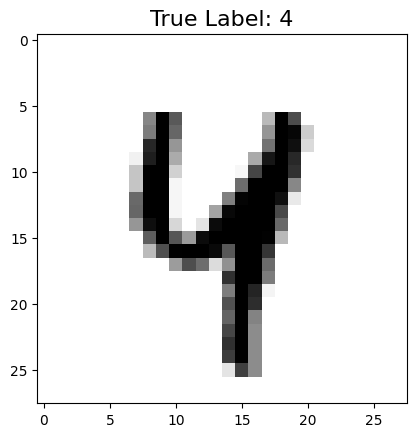

In [6]:
idx = 42

plt.imshow(test_images[idx].reshape(28,28), cmap=plt.cm.binary)
plt.title('True Label: {}'.format(test_labels[idx]), fontdict={'size': 16})
plt.show()

## Build a Model

In the cell below build a `tf.keras.Sequential` model that can be used to classify the images of the MNIST dataset. Feel free to use the simplest possible CNN. Make sure your model has the correct `input_shape` and the correct number of output units.

In [7]:
# EXERCISE: Create a model.
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(8, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 8)         80        
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 8)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        2336      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 32)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 800)               0         
                                                                 
 dense (Dense)               (None, 256)              

## Train the Model

In the cell below configure your model for training using the `adam` optimizer, `sparse_categorical_crossentropy` as the loss, and `accuracy` for your metrics. Then train the model for the given number of epochs, using the `train_images` array.

In [8]:
# EXERCISE: Configure the model for training.
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

epochs = 5

# EXERCISE: Train the model.
history = model.fit(train_images, train_labels, epochs=epochs, verbose=2)


Epoch 1/5


1875/1875 - 15s - loss: 0.1487 - accuracy: 0.9550 - 15s/epoch - 8ms/step
Epoch 2/5
1875/1875 - 13s - loss: 0.0501 - accuracy: 0.9848 - 13s/epoch - 7ms/step
Epoch 3/5
1875/1875 - 12s - loss: 0.0336 - accuracy: 0.9894 - 12s/epoch - 7ms/step
Epoch 4/5
1875/1875 - 13s - loss: 0.0242 - accuracy: 0.9922 - 13s/epoch - 7ms/step
Epoch 5/5
1875/1875 - 14s - loss: 0.0193 - accuracy: 0.9937 - 14s/epoch - 7ms/step


## Evaluate the Model

In [9]:
# EXERCISE: Evaluate the model on the test images.
results_eval = model.evaluate(test_images, test_labels, verbose=0)

for metric, value in zip(model.metrics_names, results_eval):
    print(metric + ': {:.3}'.format(value))

loss: 0.0316
accuracy: 0.991


## Save the Model

In [10]:
MODEL_DIR = tempfile.gettempdir()

version = 1

export_path = os.path.join(MODEL_DIR, str(version))

if os.path.isdir(export_path):
    print('\nAlready saved a model, cleaning up\n')
    !rm -r {export_path}

model.save(export_path, save_format="tf")

print('\nexport_path = {}'.format(export_path))
!ls -l {export_path}

INFO:tensorflow:Assets written to: C:\Users\lenovo\AppData\Local\Temp\1\assets


INFO:tensorflow:Assets written to: C:\Users\lenovo\AppData\Local\Temp\1\assets



export_path = C:\Users\lenovo\AppData\Local\Temp\1


'ls' is not recognized as an internal or external command,
operable program or batch file.


## Examine Your Saved Model

In [11]:
!saved_model_cli show --dir {export_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 28, 28, 1)
        name: serving_default_input_1:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict
The MetaGraph with tag set ['serve'] contains the following ops: {'MergeV2Checkpoints', 'BiasAdd', 'Pack', 'MaxPool', 'Reshape', 'I

## Add TensorFlow Serving Distribution URI as a Package Source

In [ ]:
# This is the same as you would do from your command line, but without the [arch=amd64], and no sudo
# You would instead do:
# echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && \
# curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -

!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update

## Install TensorFlow Serving

In [ ]:
!apt-get install tensorflow-model-server

## Run the TensorFlow Model Server

You will now launch the TensorFlow model server with a bash script. In the cell below use the following parameters when running the TensorFlow model server:

* `rest_api_port`: Use port `8501` for your requests.


* `model_name`: Use `digits_model` as your model name. 


* `model_base_path`: Use the environment variable `MODEL_DIR` defined below as the base path to the saved model.

In [ ]:
os.environ["MODEL_DIR"] = MODEL_DIR

In [ ]:
# EXERCISE: Fill in the missing code below.
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port= 8501 \
  --model_name= mnist_model \
  --model_base_path= "${MODEL_DIR}" >server.log 2>&1

In [ ]:
!tail server.log

## Create JSON Object with Test Images

In the cell below construct a JSON object and use the first three images of the testing set (`test_images`) as your data.

In [ ]:
# EXERCISE: Create JSON Object
data = json.dumps(
    {"signature_name": "serving_default",
     "instances": test_images[0:3].tolist()}
)

## Make Inference Request

In the cell below, send a predict request as a POST to the server's REST endpoint, and pass it your test data. You should ask the server to give you the latest version of your model.

In [ ]:
# EXERCISE: Fill in the code below
headers = {"content-type": "application/json"}

url = "http://localhost:8501/v1/models/mnist_model:predict"

json_response = requests.post(
    url,
    data=data,
    headers=headers
)
    
predictions = json.loads(json_response.text)['predictions']

## Plot Predictions

In [ ]:
plt.figure(figsize=(10,15))

for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(test_images[i].reshape(28,28), cmap = plt.cm.binary)
    plt.axis('off')
    color = 'green' if np.argmax(predictions[i]) == test_labels[i] else 'red'
    plt.title('Prediction: {}\nTrue Label: {}'.format(np.argmax(predictions[i]), test_labels[i]), color=color)
    
plt.show()